# Anomaly detection using the swithing Kalman filter
This tutorial example presents how to detect anomalies that take the form of change points. The model relies on the switching Kalman filter (SKF) that estimates the probability of the local trend regime versus a local acceleration regime, whereas a high probability for the later indicates the presence of a change point in a time series.

The calibration of the LSTM neural network relies on the raw traning set that is deemed to be stationnary and the SKF hyperparameters are estimated using synthetic anomalies that are added on the raw traning set. 

In this example, we use a simple sine-like signal onto which we add a synthetic regime change marking the time series swithcing from a stationnary regime to a trend-statinnary one.

### Import libraries
Import the various libraries that will be employed in this example.

In [1]:
import copy
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytagi import Normalizer as normalizer
import pytagi.metric as metric


### Import from Canari
From Canari, we need to import several classes that will be reused in this example. Notably, we need to import the components that will be used to build the model; In terms of baselines, we the SKF will build two competing models using respectively the `LocalTrend` and `LocalAcceleration` components. The recurrent pattern is modelled using a `LstmNetwork` and the residual is modelled by a `WhiteNoise` component.

In [2]:
from canari import (
    DataProcess,
    Model,
    SKF,
    plot_data,
    plot_prediction,
    plot_states,
    plot_skf_states,
)
from canari.component import LocalTrend, LocalAcceleration, LstmNetwork, WhiteNoise

### Read data
The raw `.csv` data is saved in a dataframe using the Pandas external library.

In [3]:
project_root = Path.cwd().resolve().parents[1]
data_file = str(project_root / "data/toy_time_series/sine.csv")
df = pd.read_csv(data_file, skiprows=1, delimiter=",", header=None)
# Add synthetic anomaly to data
trend = np.linspace(0, 0, num=len(df))
time_anomaly = 120
new_trend = np.linspace(0, 1, num=len(df) - time_anomaly)
trend[time_anomaly:] = trend[time_anomaly:] + new_trend
df = df.add(trend, axis=0)
#
data_file_time = str(project_root / "data/toy_time_series/sine_datetime.csv")
time_index = pd.read_csv(data_file_time, skiprows=1, delimiter=",", header=None)
time_index = pd.to_datetime(time_index[0])
df.index = time_index
df.index.name = "time"
df.columns = ["values"]

### Data preprocess
In terms of pre-processsing, we want to add the _hour-of-the-day_ as time-covariate for the LSTM network. Moreover we define here our choice of using the first 40% of the raw time series for trainig and the following 10% for the validaiton set. The remaining last 50% are the implicitely defined as the test set. 

In [4]:
output_col = [0]
data_processor = DataProcess(
    data=df,
    time_covariates=["hour_of_day"],
    train_split=0.4,
    validation_split=0.1,
    output_col=output_col,
)
train_data, validation_data, test_data, all_data = data_processor.get_splits()
data_processor.data.head()

,values,hour_of_day
time,,
2000-01-03 00:00:00,0.00,0.0
2000-01-03 01:00:00,-0.26,1.0
2000-01-03 02:00:00,-0.50,2.0
2000-01-03 03:00:00,-0.71,3.0
2000-01-03 04:00:00,-0.87,4.0


### Define components
We instantiatiate each component from their corresponding class. Both the `local_trend` and `local_acceleration` baseline components will rely on default hyperparameters. The recurrent `pattern` will use a 1-layer LSTM neural network with 50 hidden units with a look-back length of 10. The look-back window consists in the set of past neural network's outputs that are employed as explanatory variables in order to predict the current output. The `residual` is modelled by a Gaussian white noise with a mean 0 and a user-defined standard deviation of 0.05. 

In [5]:
local_trend = LocalTrend()
local_acceleration = LocalAcceleration()
pattern = LstmNetwork(
    look_back_len=10,
    num_features=2,
    num_layer=1,
    num_hidden_unit=50,
    device="cpu",
    manual_seed=1,
)
residual = WhiteNoise(std_error=5e-2)

### Define the normal and abnormal models
The SKF requires defining a normal and an abnormal model. Here, the normal one uses a local trend component with no acceleration, and the abnormal one uses a local acceleration component. The former represents a trend-stationnary regime, white the latter represents a transitory changepoint with non-zero acceleration. Note that both the normal and abnormal models share the same `pattern` and `residual` components.

In [6]:
# Normal model
model = Model(local_trend, pattern, residual)

#  Abnormal model
ab_model = Model(local_acceleration, pattern, residual)

### Define the Switching Kalman Filter (SKF) model
We instantiate and initialize the SKF model by providing 1) the standard deviation of the process error that is added when transiting from the normal to the abnormal model, and 2) the prior probability of having a regime switch fron normal to abnormal, here set to 0.0001.

Note that we use `auto_initialize_baseline_states` in order to automatically initialize the baseline hidden states based on the first three years of data.

In [7]:
skf = SKF(
    norm_model=model,
    abnorm_model=ab_model,
    std_transition_error=1e-4,
    norm_to_abnorm_prob=1e-4,
)
skf.auto_initialize_baseline_states(train_data["y"][0 : 24])

### Train the LSTM neural network model
The first step is to train the LSTM neural network model associated with the _normal_ model using the training and validation sets. The training set is used to perform the time series decomposition into a baseline, pattern and residual and to simultanously learn the LSTM neural network parameters. The validation set is used in order to identify the optimal training epoch for the LSTM neural network. Note that it is essential to perform this training on a dataset that is either stationnary or trend-stationnary. 

In [8]:

num_epoch = 50
states_optim = None
mu_validation_preds_optim = None
std_validation_preds_optim = None

for epoch in range(num_epoch):
    mu_validation_preds, std_validation_preds, states = skf.lstm_train(
        train_data=train_data,
        validation_data=validation_data,
    )
    skf.model["norm_norm"].set_memory(states=states, time_step=0)
    
    # Unstandardize the predictions
    mu_validation_preds_unnorm = normalizer.unstandardize(
        mu_validation_preds,
        data_processor.scale_const_mean[data_processor.output_col],
        data_processor.scale_const_std[data_processor.output_col],
    )

    std_validation_preds_unnorm = normalizer.unstandardize_std(
        std_validation_preds,
        data_processor.scale_const_std[data_processor.output_col],
    )

    validation_obs = data_processor.get_data("validation").flatten()
    validation_log_lik = metric.log_likelihood(
        prediction=mu_validation_preds_unnorm,
        observation=validation_obs,
        std=std_validation_preds_unnorm,
    )

    skf.early_stopping(evaluate_metric=-validation_log_lik, current_epoch=epoch, max_epoch=num_epoch)

    if epoch == skf.optimal_epoch:
        mu_validation_preds_optim = mu_validation_preds.copy()
        std_validation_preds_optim = std_validation_preds.copy()
        states_optim = copy.copy(states)

    if skf.stop_training:
        break

print(f"Optimal epoch               : {skf.optimal_epoch}")
print(f"Validation Log-likelihood   :{skf.early_stop_metric: 0.4f}")

Optimal epoch               : 49
Validation Log-likelihood   :-1.5481


### Anomaly detection
Once the training is complete, we perform the changepoint detection by using the SKF `filter` or `smoother`. The `filter` represents the results obtained during online data processing and the `smoother` those obtained during offline processing.

In [ ]:
filter_marginal_abnorm_prob, states = skf.filter(data=all_data)
smooth_marginal_abnorm_prob, states = skf.smoother(matrix_inversion_tol=1e-3, tol_type="absolute")

### Hidden states and proability of anomalies
We represent the time-series decomposition visually where the raw data is overlaid with the baseline hidden state represented by the _level_. The rate of change of the baseline is caracterised by the _trend_ and _acceleration_ hidden states. The recurrent pattern is captured by the LSTM neural network. The posterior estimate for the residuals are displayed for the white noise component. Finaly, the probability of anomaly obtained from the SKF indicated the possible location of change point from a stationnary regime to a trend-stationnary one.   

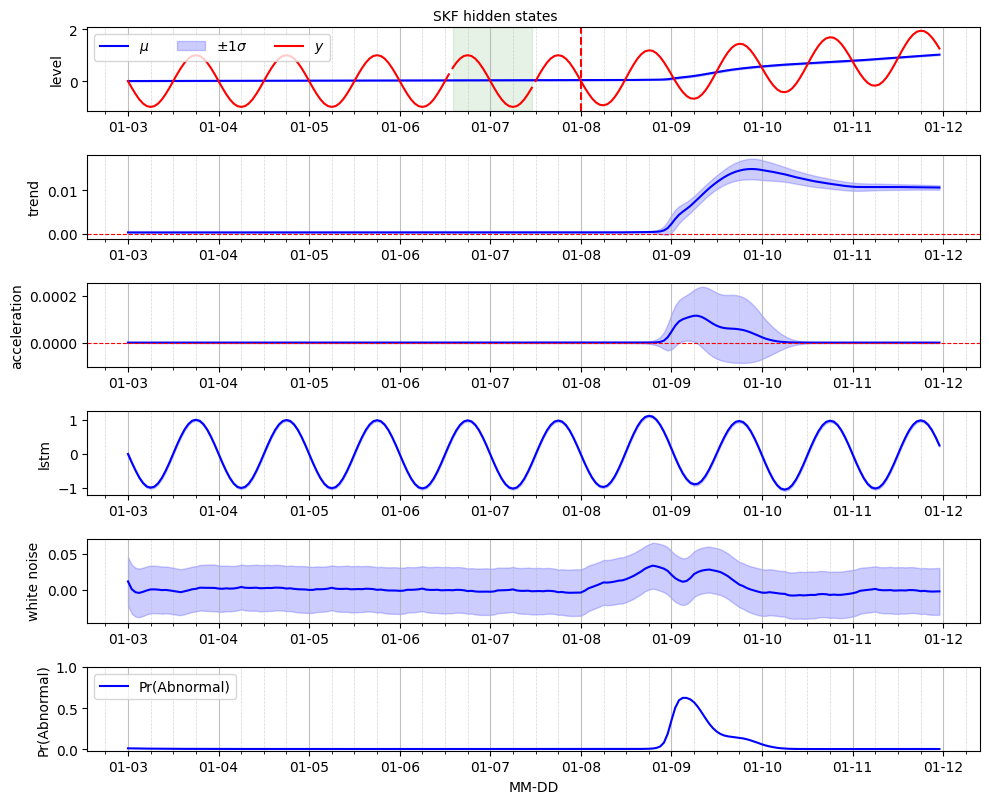

In [10]:
fig, ax = plot_skf_states(
    data_processor=data_processor,
    states=states,
    model_prob=filter_marginal_abnorm_prob,
    legend_location="upper left",
)
ax[0].axvline(
    x=data_processor.data.index[time_anomaly],
    color="r",
    linestyle="--",
)
fig.suptitle("SKF hidden states", fontsize=10, y=1)
ax[-1].set_xlabel("MM-DD")
plt.show()

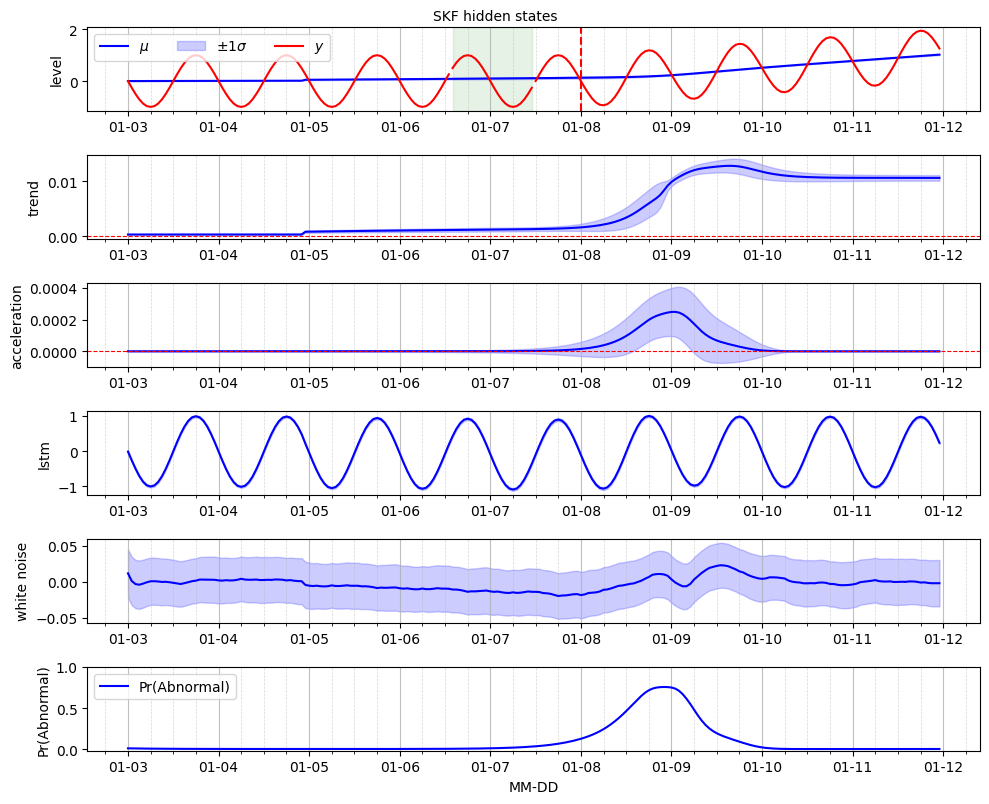

In [11]:
fig, ax = plot_skf_states(
    data_processor=data_processor,
    states=states,
    model_prob=smooth_marginal_abnorm_prob,
    states_type="smooth",
    legend_location="upper left",
)
ax[0].axvline(
    x=data_processor.data.index[time_anomaly],
    color="r",
    linestyle="--",
)
fig.suptitle("SKF hidden states", fontsize=10, y=1)
ax[-1].set_xlabel("MM-DD")
plt.show()